In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
df = pd.read_csv('../data/raw/ems_2025_merged.csv')
df

,incident_id,datetime,initial_type,initial_severity,final_type,final_severity,assignment_time,valid_dispatch_response,dispatch_response_sec,activation_time,...,datetime_hour,datetime_weather,temperture,precipitation,windspeed,weathercode,latitude_of_call,longitude_of_call,closest_station_name,closest_station_manhattan_miles
0,250010001,2025-01-01 00:00:12,STNDBY,8,STNDBY,8,2025-01-01T09:53:41.000,N,0,2025-01-01T09:57:09.000,...,2025-01-01 00:00:00,2025-01-01 00:00:00,46.8,0.0,10.7,3,40.5771,-73.9881,Engine 318/Ladder 166,0.300912
1,250010003,2025-01-01 00:01:53,UNC,2,UNC,2,2025-01-01T00:02:06.000,Y,13,2025-01-01T00:02:43.000,...,2025-01-01 00:00:00,2025-01-01 00:00:00,46.8,0.0,10.7,3,40.7506,-73.9971,Engine 34/Ladder 21,0.446225
2,250010004,2025-01-01 00:01:58,CARD,3,CARD,3,2025-01-01T00:01:58.000,Y,0,2025-01-01T00:01:58.000,...,2025-01-01 00:00:00,2025-01-01 00:00:00,46.8,0.0,10.7,3,40.7590,-73.9899,Battalion 9/Engine 54/Ladder 4,0.280244
3,250010007,2025-01-01 00:03:42,ABDPN,5,ABDPN,5,2025-01-01T00:03:59.000,Y,17,2025-01-01T00:04:12.000,...,2025-01-01 00:00:00,2025-01-01 00:00:00,46.8,0.0,10.7,3,40.8583,-73.9301,Engine 95/Ladder 36,0.712385
4,250010008,2025-01-01 00:04:36,STATEP,2,STATEP,2,2025-01-01T00:05:06.000,Y,30,2025-01-01T00:05:18.000,...,2025-01-01 00:00:00,2025-01-01 00:00:00,46.8,0.0,10.7,3,40.8899,-73.8466,Battalion 15/Engine 63/Ladder 39,0.668752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616879,243660980,2024-12-31 06:22:21,EDP,7,EDPC,7,NaN,N,0,NaN,...,2024-12-31 06:00:00,2024-12-31 06:00:00,41.8,0.0,8.6,0,40.8469,-73.8976,Bronx Borough Command,0.121764
1616880,243660981,2024-12-31 06:22:47,SICK,6,SICK,6,2024-12-31T06:22:56.000,Y,9,2024-12-31T06:23:14.000,...,2024-12-31 06:00:00,2024-12-31 06:00:00,41.8,0.0,8.6,0,40.6945,-73.9896,Brooklyn Borough Command/Division 11/Battalion...,0.416914
1616881,243660982,2024-12-31 06:23:03,DIFFBR,2,DIFFBR,2,2024-12-31T06:23:24.000,Y,21,2024-12-31T06:24:08.000,...,2024-12-31 06:00:00,2024-12-31 06:00:00,41.8,0.0,8.6,0,40.8899,-73.8466,Battalion 15/Engine 63/Ladder 39,0.668752
1616882,243660983,2024-12-31 06:23:50,EDP,7,EDPM,7,NaN,N,0,NaN,...,2024-12-31 06:00:00,2024-12-31 06:00:00,41.8,0.0,8.6,0,40.8899,-73.8466,Battalion 15/Engine 63/Ladder 39,0.668752


In [3]:
# Random Forest averages all the tree(response) predictions to get the final result (time).
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
df.columns

Index(['incident_id', 'datetime', 'initial_type', 'initial_severity',
       'final_type', 'final_severity', 'assignment_time',
       'valid_dispatch_response', 'dispatch_response_sec', 'activation_time',
       'on_scene_time', 'valid_incident_response', 'travel_time_sec',
       'close_time', 'held', 'disposition', 'borough', 'dispatch_area',
       'zipcode', 'precinct', 'council_district', 'community_district',
       'school_district', 'congressional_district', 'reopened',
       'special_events', 'standby', 'transferred', 'incident_response_sec',
       'to_hospital_time', 'hospital_arrival_time', 'year', 'month', 'day',
       'week_day', 'hour', 'is_weekend', 'is_rush_hour', 'time_of_day',
       'season', 'is_holiday', 'datetime_hour', 'datetime_weather',
       'temperture', 'precipitation', 'windspeed', 'weathercode',
       'latitude_of_call', 'longitude_of_call', 'closest_station_name',
       'closest_station_manhattan_miles'],
      dtype='object')

In [5]:
keep_columns = [
    'closest_station_manhattan_miles',
    'is_weekend',
    'hour',
    'is_holiday',
    'is_rush_hour',
    'initial_severity',
    'borough',
    'temperture',
    'precipitation',
    'windspeed',
    'weathercode',
    'day',
    'month',
    'initial_type',
    'dispatch_area',
    'special_events',
    'standby',
    'held',
    'transferred']
categorical_columns = ['borough','is_rush_hour','initial_type','dispatch_area','special_events','standby','held','transferred']


In [6]:
# Winter Model
df_winter = df[df['month'].isin([1, 2, 3])].copy()
df_winter = df_winter[df_winter['incident_response_sec'].notna()]
df_winter = df_winter[df_winter['incident_response_sec'] < 7200]

X_winter = df_winter[keep_columns]

y_winter = df_winter['incident_response_sec']

X_winter_enc = pd.get_dummies(X_winter, columns=categorical_columns, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_winter_enc, y_winter, test_size=0.2, random_state=42)


winter_model = RandomForestRegressor(n_estimators=10,
                                     max_depth=15,
                                     min_samples_leaf=200,
                                     min_samples_split=100, 
                                     random_state=42, 
                                     n_jobs=-1)
winter_model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",100
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",200
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [7]:
print(X_winter.columns.tolist())

['closest_station_manhattan_miles', 'is_weekend', 'hour', 'is_holiday', 'is_rush_hour', 'initial_severity', 'borough', 'temperture', 'precipitation', 'windspeed', 'weathercode', 'day', 'month', 'initial_type', 'dispatch_area', 'special_events', 'standby', 'held', 'transferred']


In [8]:
winter_train_pred = winter_model.predict(X_train)
winter_train_rmse = np.sqrt(mean_squared_error(y_train, winter_train_pred))

In [9]:
winter_test_pred = winter_model.predict(X_test)
winter_test_rmse = np.sqrt(mean_squared_error(y_test, winter_test_pred))

In [10]:
print(f"Winter Training RMSE: {winter_train_rmse:}")
print(f"Winter Test RMSE: {winter_test_rmse:}")
print(f"Difference: {winter_test_rmse - winter_train_rmse:}sec")

Winter Training RMSE: 603.838013599846
Winter Test RMSE: 612.2557330463784
Difference: 8.417719446532374sec


In [11]:
winter_comparison = pd.DataFrame({
    'actual': y_test.values[:10],
    'predicted': winter_test_pred[:10],
    'error': y_test.values[:10] - winter_test_pred[:10]})


winter_comparison

,actual,predicted,error
0,381.0,505.347174,-124.347174
1,772.0,724.298588,47.701412
2,601.0,491.846415,109.153585
3,1210.0,1770.227587,-560.227587
4,329.0,331.384708,-2.384708
5,347.0,423.099863,-76.099863
6,218.0,538.426399,-320.426399
7,326.0,431.576171,-105.576171
8,724.0,413.028437,310.971563
9,732.0,500.767961,231.232039


In [12]:
# Spring Model
df_spring = df[df['month'].isin([4, 5, 6])].copy()
df_spring = df_spring[df_spring['incident_response_sec'].notna()] # since so much data i just used what was na
df_spring = df_spring[df_spring['incident_response_sec'] < 7200]

X_spring = df_spring[keep_columns]
y_spring = df_spring['incident_response_sec']

X_spring_enc = pd.get_dummies(X_spring, columns=categorical_columns, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X_spring_enc, y_spring, test_size=0.2, random_state=42)


spring_model = RandomForestRegressor(n_estimators=10, 
                                     max_depth=15,
                                     min_samples_split=100,
                                     min_samples_leaf=200,
                                     random_state=42, 
                                     n_jobs=-1)
spring_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",100
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",200
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [13]:
print(X_spring.columns.tolist())

['closest_station_manhattan_miles', 'is_weekend', 'hour', 'is_holiday', 'is_rush_hour', 'initial_severity', 'borough', 'temperture', 'precipitation', 'windspeed', 'weathercode', 'day', 'month', 'initial_type', 'dispatch_area', 'special_events', 'standby', 'held', 'transferred']


In [14]:
spring_train_pred = spring_model.predict(X_train)
spring_train_rmse = np.sqrt(mean_squared_error(y_train, spring_train_pred))

In [15]:
spring_test_pred = spring_model.predict(X_test)
spring_test_rmse = np.sqrt(mean_squared_error(y_test, spring_test_pred))

In [16]:
print(f" Spring training RMSE: {spring_train_rmse} sec")
print(f"spring test RMSE: {spring_test_rmse:} sec")
print(f"Difference: {spring_test_rmse - spring_train_rmse:} sec")

 Spring training RMSE: 616.8911927208626 sec
spring test RMSE: 627.2760944320275 sec
Difference: 10.384901711164957 sec


In [17]:
spring_comparison = pd.DataFrame({
    'actual': y_test.values[:10],
    'predicted': spring_test_pred[:10],
    'error': y_test.values[:10] - spring_test_pred[:10]})


spring_comparison

,actual,predicted,error
0,244.0,423.329092,-179.329092
1,569.0,691.844069,-122.844069
2,593.0,547.980339,45.019661
3,483.0,549.327444,-66.327444
4,141.0,482.282339,-341.282339
5,998.0,665.343566,332.656434
6,367.0,414.517842,-47.517842
7,828.0,746.480101,81.519899
8,631.0,840.967007,-209.967007
9,284.0,551.440749,-267.440749


In [18]:
# Summer model
df_summer = df[df['month'].isin([7,8,9])].copy() 
df_summer = df_summer[df_summer['incident_response_sec'].notna()]
df_summer = df_summer[df_summer['incident_response_sec']< 7200]

X_summer = df_summer[keep_columns]
y_summer = df_summer['incident_response_sec']

X_summer_enc = pd.get_dummies(X_summer, columns=categorical_columns, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_summer_enc,y_summer, random_state=42, test_size=0.2)

summer_model = RandomForestRegressor(n_estimators=10,
                                     min_samples_leaf=100,
                                     min_samples_split=200,
                                     max_depth=15,
                                     random_state=42,
                                     n_jobs=-1)
summer_model.fit(X_train,y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",200
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",100
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [19]:
print(X_summer.columns.tolist())

['closest_station_manhattan_miles', 'is_weekend', 'hour', 'is_holiday', 'is_rush_hour', 'initial_severity', 'borough', 'temperture', 'precipitation', 'windspeed', 'weathercode', 'day', 'month', 'initial_type', 'dispatch_area', 'special_events', 'standby', 'held', 'transferred']


In [20]:
summer_train_pred = summer_model.predict(X_train)
summer_train_rmse = np.sqrt(mean_squared_error(y_train, summer_train_pred))

In [21]:
summer_test_pred = summer_model.predict(X_test)
summer_test_rmse = np.sqrt(mean_squared_error(y_test, summer_test_pred))

In [22]:
print(f" Summer training RMSE: {summer_train_rmse} sec")
print(f"summer test RMSE: {summer_test_rmse} sec")
print(f"Difference: {summer_test_rmse - summer_train_rmse:} sec")

 Summer training RMSE: 646.5863006643604 sec
summer test RMSE: 671.1793076072082 sec
Difference: 24.593006942847865 sec


In [23]:
summer_comparison = pd.DataFrame({
    'actual': y_test.values[:10],
    'predicted': summer_test_pred[:10],
    'error': y_test.values[:10] - summer_test_pred[:10]})


summer_comparison

,actual,predicted,error
0,120.0,625.782089,-505.782089
1,676.0,794.182419,-118.182419
2,1720.0,1383.345581,336.654419
3,265.0,383.962705,-118.962705
4,2965.0,2499.883236,465.116764
5,291.0,420.868076,-129.868076
6,609.0,447.210980,161.789020
7,649.0,589.562308,59.437692
8,186.0,310.990665,-124.990665
9,339.0,403.312314,-64.312314


In [24]:
# Fall Model
df_fall = df[df['month'].isin([10, 11, 12])].copy()
df_fall = df_fall[df_fall['incident_response_sec'].notna()]
df_fall = df_fall[df_fall['incident_response_sec'] < 7200]

X_fall = df_fall[keep_columns]
y_fall = df_fall['incident_response_sec']

X_fall_enc = pd.get_dummies(X_fall, columns=categorical_columns, drop_first=True)


#X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_train, X_test, y_train, y_test = train_test_split(X_fall_enc, y_fall, test_size=0.2, random_state=42)


fall_model = RandomForestRegressor(n_estimators=10,
                                   max_depth=15,
                                   min_samples_leaf=200,
                                   min_samples_split=100, 
                                   random_state=42, 
                                   n_jobs=-1)
fall_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",100
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",200
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [25]:
print(X_fall.columns.tolist())

['closest_station_manhattan_miles', 'is_weekend', 'hour', 'is_holiday', 'is_rush_hour', 'initial_severity', 'borough', 'temperture', 'precipitation', 'windspeed', 'weathercode', 'day', 'month', 'initial_type', 'dispatch_area', 'special_events', 'standby', 'held', 'transferred']


In [26]:
fall_train_pred = fall_model.predict(X_train)
fall_train_rmse = np.sqrt(mean_squared_error(y_train, fall_train_pred))

In [27]:
fall_test_pred = fall_model.predict(X_test)
fall_test_rmse = np.sqrt(mean_squared_error(y_test, fall_test_pred))

In [28]:
print(f" Fall training RMSE: {fall_train_rmse:} sec")
print(f"Fall test RMSE: {fall_test_rmse:} sec")
print(f"Difference: {fall_test_rmse - fall_train_rmse:} sec")

 Fall training RMSE: 601.1415294515097 sec
Fall test RMSE: 594.81101087937 sec
Difference: -6.330518572139681 sec


In [29]:
fall_comparison = pd.DataFrame({
    'actual': y_test.values[:10],
    'predicted': fall_test_pred[:10],
    'error': y_test.values[:10] - fall_test_pred[:10]})


fall_comparison

,actual,predicted,error
0,408.0,404.059917,3.940083
1,975.0,756.976249,218.023751
2,479.0,449.863339,29.136661
3,2488.0,3199.086359,-711.086359
4,206.0,717.577928,-511.577928
5,751.0,1847.176696,-1096.176696
6,423.0,488.007858,-65.007858
7,842.0,477.648700,364.351300
8,387.0,470.674573,-83.674573
9,0.0,515.253840,-515.253840


In [30]:
average_test_rmse = (winter_test_rmse + spring_test_rmse + summer_test_rmse + fall_test_rmse) / 4 # divided by 4 seasons to ger average
average_train_rmse = (winter_train_rmse + spring_train_rmse + summer_test_rmse + fall_test_rmse) /4

In [31]:
print(f"Training RMSE: {average_train_rmse:} sec")
print(f"Test RMSE: {average_test_rmse:} sec")
print(f"Difference: {average_test_rmse - average_train_rmse} sec")

Training RMSE: 621.6798812018217 sec
Test RMSE: 626.380536491246 sec
Difference: 4.700655289424276 sec


In [32]:
# first try 17 min is bad (bad date set)
# second try is 11 minutes lowered the time less than 2 hours (used less than 2 hours)
# third try with new data set 13 min
# fourth try 12 min using by season winter
# once broken down by season i got better results 15 min avg response time
# with 3 seasons is it still posibile to show case this 
# possible hypothesis testing 
# 10 second imporovement by adding is_holiday to the model really good sign the model is learning
# tweeked the model max dept ect.

In [33]:
overall_avg = df['incident_response_sec'].mean()
print(f"\nOverall Average: {overall_avg/60:.2f} minutes")



Overall Average: 14.91 minutes


-----------------------------------------------------------------------------------------------------------------------------------------------------------

hypothesis testing

In [34]:
#t here is no difference in mean emergency response times across seasons (winter, spring, summer)
# if i fill in the mean my hypothesis could be invalid so dropna() and keep what i have for the test 
# questioning why they are different and how they are different 
# can i prove that the response time is even valid across season weather holidays ect. 

In [35]:
# Can you export your Random Forest predictions aggregated at the hourly level 
# as a CSV with datetime_hour and rf_pred_response_sec? I need it for Tableau.

In [36]:
from scipy import stats

winter = df[df['season'] == 'winter']['incident_response_sec'].dropna()
spring = df[df['season'] == 'spring']['incident_response_sec'].dropna()
summer = df[df['season'] == 'summer']['incident_response_sec'].dropna()
fall = df[df['season'] == 'fall']['incident_response_sec'].dropna()

f_stat, p_value = stats.f_oneway(winter, spring, summer,fall)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

#0.05 is the standard threshold
if p_value < 0.05:
    print("seasons have different response times")
else:
    print("Response times are the same across winter/spring/summer")

F-statistic: 1407.9921879393653
P-value: 0.0
seasons have different response times


In [37]:
# response times are different across seasons

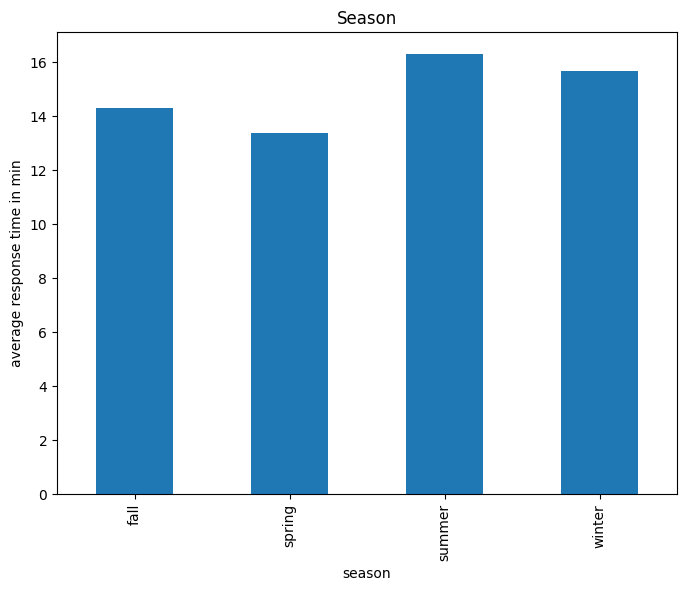

In [38]:
means = df.groupby('season')['incident_response_sec'].mean() / 60

plt.figure(figsize=(8, 6))
means.plot(kind='bar')
plt.ylabel('average response time in min')
plt.title('Season')
plt.show()

In [39]:
# can you export your Random Forest predictions aggregated at the hourly level as 
# a CSV with datetime_hour and rf_pred_response_sec? I need it for Tableau

In [40]:
import os
import pickle

os.makedirs("../data/models", exist_ok=True)

models = {
    "winter": winter_model,
    "spring": spring_model,
    "summer": summer_model,
    "fall": fall_model}

with open("../data/models/season_models.pkl", "wb") as f:
    pickle.dump(models, f)


-------------------------------------------------------------------------------------------------------------------------------------------------------

In [49]:
all_predictions = []
# winter
X_train, X_test, y_train, y_test = train_test_split(X_winter_enc, y_winter, test_size=0.2, random_state=42)
winter_preds = winter_model.predict(X_test)
winter_dates = df_winter.loc[y_test.index, 'datetime'].values
all_predictions.append(pd.DataFrame({'datetime': winter_dates,'rf_pred_response_sec': winter_preds}))
# spring
X_train, X_test, y_train, y_test = train_test_split(X_spring_enc, y_spring, test_size=0.2, random_state=42)
spring_preds = spring_model.predict(X_test)
spring_dates = df_spring.loc[y_test.index, 'datetime'].values
all_predictions.append(pd.DataFrame({'datetime': spring_dates,'rf_pred_response_sec': spring_preds}))
# summer
X_train, X_test, y_train, y_test = train_test_split(X_summer_enc, y_summer, test_size=0.2, random_state=42)
summer_preds = summer_model.predict(X_test)
summer_dates = df_summer.loc[y_test.index, 'datetime'].values
all_predictions.append(pd.DataFrame({'datetime': summer_dates,'rf_pred_response_sec': summer_preds}))
# fall
X_train, X_test, y_train, y_test = train_test_split(X_fall_enc, y_fall, test_size=0.2, random_state=42)
fall_preds = fall_model.predict(X_test)
fall_dates = df_fall.loc[y_test.index, 'datetime'].values
all_predictions.append(pd.DataFrame({'datetime': fall_dates,'rf_pred_response_sec': fall_preds}))
    

In [50]:
combined = pd.concat(all_predictions, ignore_index=True)
combined['datetime_hour'] = pd.to_datetime(combined['datetime']).dt.floor('H')
hourly_preds = combined.groupby('datetime_hour')['rf_pred_response_sec'].mean().reset_index()
hourly_preds = hourly_preds.sort_values('datetime_hour').reset_index(drop=True)

C:\Users\ayman\AppData\Local\Temp\ipykernel_20468\4173566753.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  combined['datetime_hour'] = pd.to_datetime(combined['datetime']).dt.floor('H')


In [43]:
hourly_preds

,datetime_hour,rf_pred_response_sec
0,2024-09-01 00:00:00,704.858226
1,2024-09-01 01:00:00,815.815019
2,2024-09-01 02:00:00,833.712965
3,2024-09-01 03:00:00,697.212243
4,2024-09-01 04:00:00,1011.608680
...,...,...
8754,2025-08-31 19:00:00,898.934576
8755,2025-08-31 20:00:00,789.052191
8756,2025-08-31 21:00:00,738.630555
8757,2025-08-31 22:00:00,677.687733


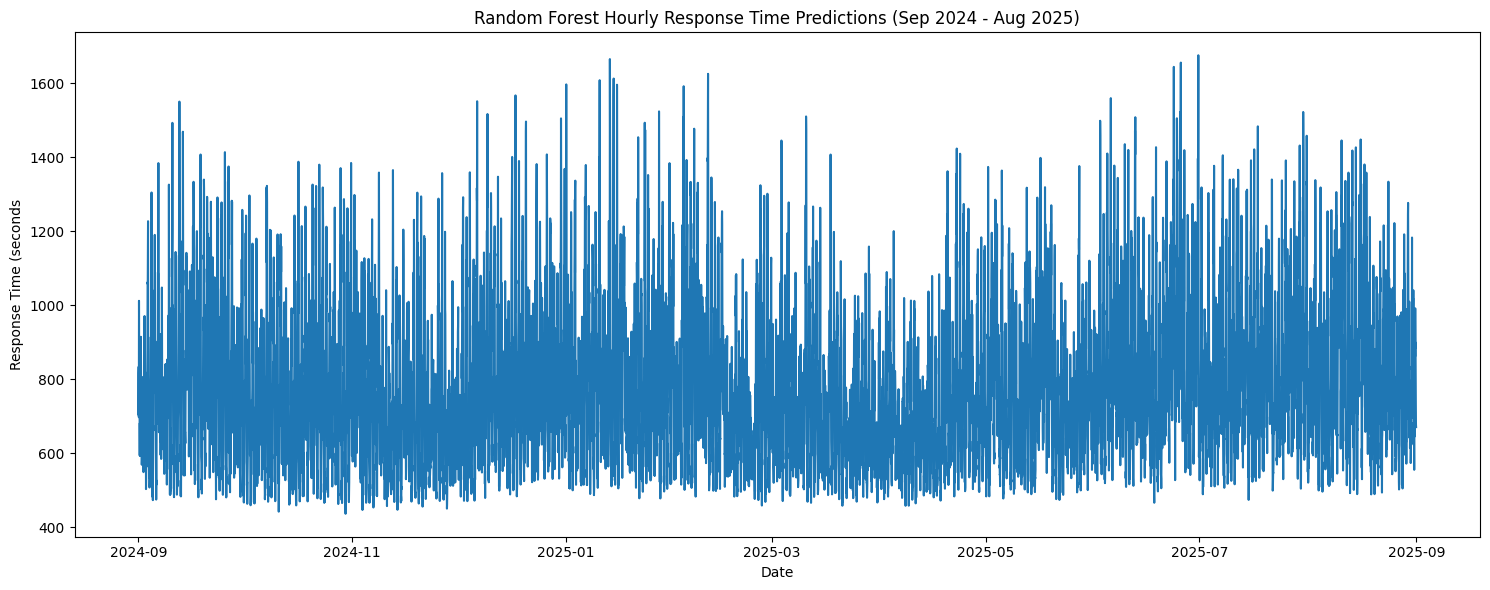

In [44]:
plt.figure(figsize=(15, 6))
plt.plot(hourly_preds['datetime_hour'], hourly_preds['rf_pred_response_sec'])
plt.xlabel('Date')
plt.ylabel('Response Time (seconds')
plt.title('Random Forest Hourly Response Time Predictions (Sep 2024 - Aug 2025)')
plt.tight_layout()
plt.show()

In [60]:

X_train, X_test, y_train, y_test = train_test_split(X_winter_enc, y_winter, test_size=0.2, random_state=42)
winter_preds = winter_model.predict(X_test)

y_test_winter = y_test


X_train, X_test, y_train, y_test = train_test_split(X_spring_enc, y_spring, test_size=0.2, random_state=42)
spring_preds = spring_model.predict(X_test)

y_test_spring = y_test


X_train, X_test, y_train, y_test = train_test_split(X_summer_enc, y_summer, test_size=0.2, random_state=42)
summer_preds = summer_model.predict(X_test)

y_test_summer = y_test


X_train, X_test, y_train, y_test = train_test_split(X_fall_enc, y_fall, test_size=0.2, random_state=42)
fall_preds = fall_model.predict(X_test)

y_test_fall = y_test

In [76]:
# create a list to show
seasons = [
    ("winter", y_test_winter, winter_preds),
    ("spring", y_test_spring, spring_preds),
    ("summer", y_test_summer, summer_preds),
    ("fall",   y_test_fall,   fall_preds)]

In [77]:
print(type(seasons))

<class 'list'>


In [78]:
for name, y_true, y_pred in seasons:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name}      RMSE: {rmse} sec        MAE: {mae} sec          R2: {r2} sec")

winter      RMSE: 612.2557330463784 sec        MAE: 352.09328964377147 sec          R2: 0.47834617190060247 sec
spring      RMSE: 627.2760944320274 sec        MAE: 364.0636687558043 sec          R2: 0.45511460594559416 sec
summer      RMSE: 671.1793076072082 sec        MAE: 388.03865516279194 sec          R2: 0.46140142802232786 sec
fall      RMSE: 594.81101087937 sec        MAE: 346.3888748244134 sec          R2: 0.46521097023995217 sec


In [47]:
hourly_preds.to_csv('../data/raw/hourly_rf_predictions.csv', index=False)

-----------------------------------------------------------------------------------------------------------------------------------------------------------

# RAG (Retrieval-Augmented Generation) system with LangChain + ChromaDB + OpenAI

langchain - Main LangChain framework


langchain-openai - OpenAI integration (ChatGPT, embeddings)


langchain-community - Community tools (Chroma vector store)


langchain-core - Core utilities (Document class)


chromadb - Vector database for storing embeddings


openai - OpenAI Python SDK


python-dotenv - Load environment variables from .env file

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
import openai


load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

In [33]:
docs = [
    Document(page_content="Winter: 12 min avg response time, 258K incidents. Slower due to snow/ice. Built separate Random Forest model."),
    Document(page_content="ANOVA: p<0.001. Seasons differ significantly. This justified building seasonal models instead of one general model."),
    Document(page_content="Top features: 1. Station distance (most important) 2. Hour of day 3. Initial severity. Adding is_holiday improved RMSE by 10 seconds."),
    Document(page_content="Performance evolution: Started 17 min RMSE  after cleaning 11 min  final 12 min with seasonal models. 35% improvement overall."),
    Document(page_content= "Source: NYC Open Data API (https://data.cityofnewyork.us/resource/76xm-jjuj.json)")]




In [34]:
embeddings = OpenAIEmbeddings(openai_api_key=api_key)
vectorstore = Chroma.from_documents(docs, embeddings)

In [35]:
llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=api_key)

In [36]:
def ask(question):
    # Find relevant context
    context = "\n".join([d.page_content for d in vectorstore.similarity_search(question, k=2)])
    # Ask LLM (use invoke instead of predict)
    response = llm.invoke(f"Context: {context}\n\nQuestion: {question}\nAnswer:")
    return response.content  # Extract the text content

In [ ]:
questions = [
    "Why did we use seasonal models?",
    "What was the most important feature?",
    "How much did the model improve?"
]

In [ ]:
for q in questions:
    print(f"Q: {q}")
    print(f"A: {ask(q)}\n")
    print("-"*60 + "\n")

Q: Why did we use seasonal models?
A: We used seasonal models because the ANOVA test showed that seasons differ significantly, indicating that there are significant differences in data patterns across different seasons. Building seasonal models allows for more accurate and tailored predictions for each season, instead of using one general model that may not capture these seasonal variations.

------------------------------------------------------------

Q: What was the most important feature?
A: The most important feature was station distance.

------------------------------------------------------------

Q: How much did the model improve?
A: The model improved by 35%.

------------------------------------------------------------



In [ ]:
print(ask("What was our sample size?"))
print(ask("How did weather affect response times?"))
print(ask("What statistical test did we use?"))
print(ask("Why was distance important?"))
print(ask("What was the RMSE?"))
print(ask("How many incidents were in winter?"))

The sample size is not provided in the given context.
The weather, specifically snow and ice during the winter season, caused response times to be slower with an average of 12 minutes for 258,000 incidents. To account for this impact, a separate Random Forest model was built to factor in the weather conditions and improve response time predictions.
ANOVA (Analysis of Variance)
Distance was important because it likely had a significant impact on the time it took for emergency responders to reach the location of the incident. A shorter distance between the station and the scene of the incident would result in a quicker response time, potentially leading to better outcomes for those involved.
The RMSE started at 17 minutes, improved to 11 minutes after cleaning, and finally reached 12 minutes with seasonal models.
258,000 incidents were reported in winter.


In [ ]:
print(ask("does the model have good predictions?"))

Based on the provided information, it appears that the model has shown a significant improvement in its predictions. The initial RMSE of 17 minutes was reduced to 11 minutes after cleaning, and further improved to 12 minutes with seasonal models, resulting in a 35% overall improvement. This suggests that the model is making more accurate predictions compared to its initial performance.


In [ ]:
print(ask("What was the temperature range in our data?"))

The temperature range in our data was not provided in the given context.


In [ ]:
#echo ".env" >> .gitignore
#pip install python-dotenv openai langchain
#pip install langchain langchain-openai langchain-community langchain-core chromadb openai python-dotenv

In [ ]:
import pickle
with open(r'C:\Users\ayman\Downloads\sarima_model.pkl', 'rb') as f:
    utku_model = pickle.load(f)